In [1]:
try:
    if has_been_run:
        pass
except:
    %pip install torchdiffeq
    has_been_run = True

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from functools import partial
from torch.autograd.functional import jacobian, hessian

from torchdiffeq import odeint as tor_odeint
from torchdiffeq import odeint_adjoint as tor_odeintadj
torch.version.__version__


'2.1.2'

Lagrangian for spring pendulum, in 2D, with $r$ spring length, $\theta$ angle from vertical: 

$\mathcal{L} = T - V = \frac{1}{2}\dot{r}^2 + \frac{1}{2} r^2\dot{\theta}^2 - gr(1-\cos(\theta)) - k(r -r_0)^2$

By applying Euler Lagrange equations get:

$\ddot r = r\dot{\theta}^2 + g(1-\cos(\theta)) - 2k(r-r_0)$

and 

$\ddot \theta = -\frac{1}{r}(g\sin(\theta) + 2\dot{r}\dot{\theta})$

can use these and `odeint` to solve analytically.



In [3]:
class constant_force:
    
    def __init__(self, m, g):
        self.m = m
        self.g = g
        self.dof = 2
        self.toy_position_example = np.array([0.48])
        self.toy_velocity_example = np.array([0.31])
        self.toy_time_dataset = np.arange(0, 4, 0.001)
        self.position_bounds = (0,1)
        self.velocity_bounds = (-2,2)
        self.scale = 1
        
    def scale_constants(self, scale):
        self.scale = scale
    
    def kinetic(self, x):
        return 0.5 * self.m * x[1]**2
    
    def potential(self, x):
        return self.m * self.g/self.scale * x[0]
    
    # NEED LAGRANGIAN TO PRODUCE SCALARS, NOT TENSORS!
    def lagrangian(self, x):
        T = self.kinetic(x)
        V = self.potential(x)
        return T - V

    def energy(self, x):
        T = self.kinetic(x)
        V = self.potential(x)
        return T + V
    
    def solve_acceleration(self, q, qdot):
        return -self.g/self.scale
    
    def plot_solved_dynamics(self, t, path, labelstr = ""):
        plt.plot(t, path[:, 0], label = labelstr)
        
    def plot_lagrangian(self, t, path, lagrangian, labelstr = ""):
        plt.plot(t, [lagrangian(l) for l in path], label = labelstr)



In [4]:
class harmonic_oscillator_spring_1d:
    
    def __init__(self, m, k):
        self.m = m
        self.k = k
        self.dof = 2
        self.toy_position_example = np.array([0.3])
        self.toy_velocity_example = np.array([1.0])
        self.toy_time_dataset = np.arange(0, 4, 0.001)
        self.position_bounds = (-1,1)
        self.velocity_bounds = (-2,2)

    def scale_constants(self, scale):
        pass
        
    def kinetic(self, x):
        return 0.5 * self.m * x[1]**2
    
    def potential(self, x):
        return 0.5 * self.k * x[0]**2
    
    # NEED LAGRANGIAN TO PRODUCE SCALARS, NOT TENSORS!
    def lagrangian(self, x):
        T = self.kinetic(x)
        V = self.potential(x)
        return T - V
    
    def energy(self, x):
        T = self.kinetic(x)
        V = self.potential(x)
        return T + V
    
    def solve_acceleration(self, q, qdot):
        return -self.k * q / self.m
    
    def plot_solved_dynamics(self, t, path, labelstr = ""):
        plt.plot(t, path[:, 0], label = labelstr)

    def plot_lagrangian(self, t, path, lagrangian, labelstr = ""):
        plt.plot(t, [lagrangian(l) for l in path], label = labelstr)


In [5]:
class spring_pendulum:
    
    def __init__(self, k, g):
        self.k = k
        self.g = g
        self.dof = 4
        self.toy_position_example = np.array([1.1, 0.5])
        self.toy_velocity_example = np.array([0.0, 0.0])
        self.toy_time_dataset = np.arange(0, 5, 0.005)
        self.position_bounds = (0,1)
        self.velocity_bounds = (-2,2)
        self.scale = 1

    def scale_constants(self, scale):
        self.scale = scale
    
    def kinetic(self, q, qt):
        return 0.5*(qt[0]**2 + (q[0]*qt[1])**2)
    
    def potential(self, q, qt, cos):
        return self.g/self.scale*q[0]*(1-cos(q[1])) + self.k*(q[0] - 1)**2
    
    # NEED LAGRANGIAN TO PRODUCE SCALARS, NOT TENSORS!
    def lagrangian(self, x):
        q, qt = torch.split(x, 2)
        T = self.kinetic(q, qt)
        V = self.potential(q, qt, torch.cos)
        return T - V

    def energy(self, x):
        try:
            q, qt = torch.split(x, self.dof//2)
            cos = torch.cos
        except: 
            q, qt = np.split(x, self.dof//2)
            cos = np.cos
        T = self.kinetic(q, qt)
        V = self.potential(q, qt, cos)
        return T + V
    
    def solve_acceleration(self, q, qdot):
        '''
        q is [r, theta]
        qdot is [rdot, thetadot]

        returns q double dot.
        '''
        qdtt = np.zeros_like(q)
        
        qdtt[:, 0] = q[:, 0]*qdot[:, 1]**2 - self.g/self.scale*(1-np.cos(q[:, 1])) - 2*self.k*(q[:, 0]-1) 
        qdtt[:, 1] = (-self.g/self.scale*np.sin(q[:, 1]) -2*qdot[:, 0]*qdot[:, 1])/q[:, 0]

        return qdtt  
    
    def polar_to_cartesian(self, ql):
        '''
        Polar coords to xy
        '''
        try: 
            xy = np.zeros_like(ql)
            sin = np.sin
            cos = np.cos
        except: 
            xy = torch.zeros_like(ql)
            sin = torch.sin
            cos = torch.cos

        xy[:, 0] = ql[:, 0]*sin(ql[:, 1])
        xy[:, 1] = -ql[:, 0]*cos(ql[:, 1])
        return xy
    
    def plot_solved_dynamics(self, t, path, labelstr = ""):
        xy = self.polar_to_cartesian(path)
        plt.plot(xy[:, 0], xy[:, 1], label = labelstr)
    

In [6]:
trial = 0

if (trial == 0):
    particle = constant_force(1, 1)
    
elif (trial == 1):
    particle = harmonic_oscillator_spring_1d(1,10)
    
elif (trial == 2):
    particle = spring_pendulum(10,10)

In [7]:
def get_qdotdot(total_state, analytical_solution):
    '''
    total_state is a tensor of generalised coords and velocities,
    returns q double dot.
    '''
    dims = total_state.shape[1]
    if dims%2 != 0:
        raise ValueError("The input total_state must have an even number of columns.")
    return analytical_solution(total_state[:, :dims//2], total_state[:, dims//2:])


# Returns q_dot and q_dotdot 

#Want to make these functions as general as possible. so that they can be used for any system.

def analytically_differentiated_state(x, t, analytical_solution):
    d = torch.zeros_like(x)
    
    #Remove 2's, make it general
    n_cols = x.shape[1]
    if n_cols % 2 != 0:
        raise ValueError("The input x must have an even number of columns.")
    d[:, :n_cols//2] = x[:, n_cols//2:]
    d[:, n_cols//2:] = get_qdotdot(x, analytical_solution)
    return d


# This takes only 4 numbers: the starting position and velocity. 
# f_analytic function returns q_dot and q_dotdot for 1 dimensional inputs.

# Returns:
# An array containing the value of y for each desired time in t, with the initial value y0 in the first row.


def ode_solve_analytic(q0, qt0, t, analytical_solution):

    x0 = np.append(q0, qt0)
    def f_analytic(x, t):
        d = np.zeros_like(x)
        n_cols = x.shape[0]
        d[:n_cols//2] = x[n_cols//2:]
        d[n_cols//2:] = np.squeeze(get_qdotdot(np.expand_dims(x, axis=0), analytical_solution))
        # print(x, d)
        return d
    
    return odeint(f_analytic, x0, t, rtol=1e-10, atol=1e-10)
    



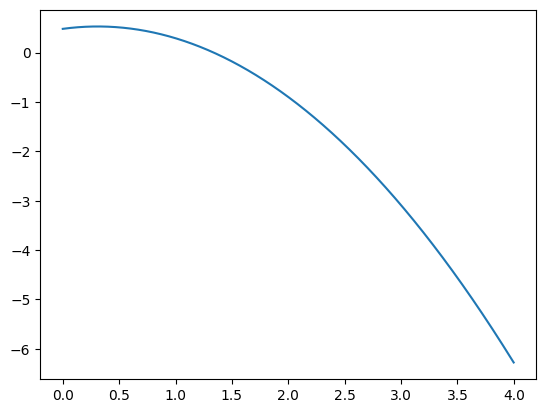

In [8]:
t = particle.toy_time_dataset
q0 = particle.toy_position_example
qt0 = particle.toy_velocity_example

path = ode_solve_analytic(q0, qt0, t, particle.solve_acceleration)

particle.plot_solved_dynamics(t, path)

We can also solve using pytorch to autodiff the lagrangian, an use the following version of the EL equations (after Cranmer et al.), with $q=(r, \theta)$:

$\ddot q = (\nabla_{\dot q}\nabla_{\dot q}^{\top}\mathcal{L})^{-1}[\nabla_q \mathcal{L} - (\nabla_{q}\nabla_{\dot q}^{\top}\mathcal{L})\dot q]$





In [9]:
# Gets the q_dot, q_dotdot by differentiating a function "lagrangian" wrt E-L equations.

# def get_diff_state_lagr(lagrangian, t, x):
#    n = x.shape[0]//2
#    xv = torch.autograd.Variable(x, requires_grad=True)
#    tq, tqt = torch.split(xv, n, dim=0)
#    A = torch.inverse(hessian(lagrangian, xv, create_graph=True)[n:, n:])
#    B = jacobian(lagrangian, xv, create_graph=True)[:n]
#    C = hessian(lagrangian, xv, create_graph=True)[n:, :n]
#    tqtt = A @ (B - C @ tqt)
#    xt = torch.cat([tqt, tqtt])

#    return xt

def get_diff_state_lagr(lagrangian, t, x):
    try:
        n = x.shape[1]//2
    except:
        x = torch.unsqueeze(x, 0)
        n = x.shape[1]//2
    print(x)
    
    xv = torch.autograd.Variable(x, requires_grad=True)
    xv_tup = tuple([xi for xi in x])
    #xv_tup is tuple of "states" in various time frames.
    tqt = xv[:, n:]

    jacpar = partial(jacobian,  lagrangian, create_graph=True)
    hesspar = partial(hessian,  lagrangian, create_graph=True)

    A = tuple(map(hesspar, xv_tup))
    B = tuple(map(jacpar, xv_tup))
    print("a",A)
    print("b",B)
    multi = lambda Ai, Bi, tqti:  torch.pinverse(Ai[n:, n:]) @ (Bi[:n] - Ai[n:, :n] @ tqti) 

    tqtt_tup = tuple(map(multi, A, B, tqt))
    tqtt = torch.cat([tqtti[None] for tqtti in tqtt_tup])
    xt = torch.cat([tqt, tqtt], axis=1)
    
    return xt

# This takes the starting coordinates and f fills the first argument of get_diff_state_lagr with "lagrangian",
# so that this can directly go into tor_odeint function, which is similar to the previous one.
def torch_solve_ode(x0, t, lagrangian):
    f = partial(get_diff_state_lagr, lagrangian)
    return tor_odeint(f, x0, t)

In [10]:
tx0 = torch.cat([torch.tensor(q0), torch.tensor(qt0)])
tt = torch.tensor(t)

tpath = torch_solve_ode(tx0, tt, particle.lagrangian)


tensor([[0.4800, 0.3100]], dtype=torch.float64)
a (tensor([[0., 0.],
        [0., 1.]], dtype=torch.float64, grad_fn=<ViewBackward0>),)
b (tensor([-1.0000,  0.3100], dtype=torch.float64, grad_fn=<ViewBackward0>),)
tensor([[0.4813, 0.3057]], dtype=torch.float64, grad_fn=<AddBackward0>)
a (tensor([[0., 0.],
        [0., 1.]], dtype=torch.float64, grad_fn=<ViewBackward0>),)
b (tensor([-1.0000,  0.3057], dtype=torch.float64, grad_fn=<ViewBackward0>),)
tensor([[0.4808, 0.3073]], dtype=torch.float64, grad_fn=<AddBackward0>)
a (tensor([[0., 0.],
        [0., 1.]], dtype=torch.float64, grad_fn=<ViewBackward0>),)
b (tensor([-1.0000,  0.3073], dtype=torch.float64, grad_fn=<ViewBackward0>),)
tensor([[0.4812, 0.3060]], dtype=torch.float64, grad_fn=<AddBackward0>)
a (tensor([[0., 0.],
        [0., 1.]], dtype=torch.float64, grad_fn=<ViewBackward0>),)
b (tensor([-1.0000,  0.3060], dtype=torch.float64, grad_fn=<ViewBackward0>),)
tensor([[0.4833, 0.2992]], dtype=torch.float64, grad_fn=<AddBackward0>)


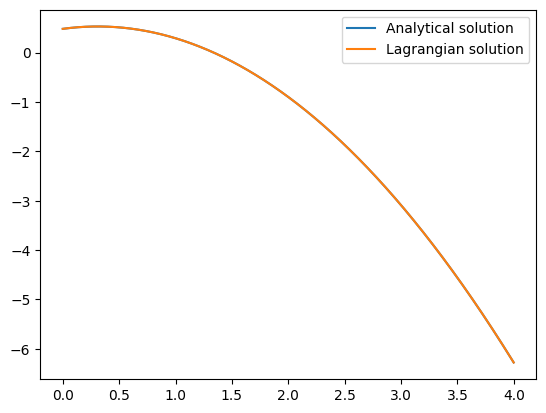

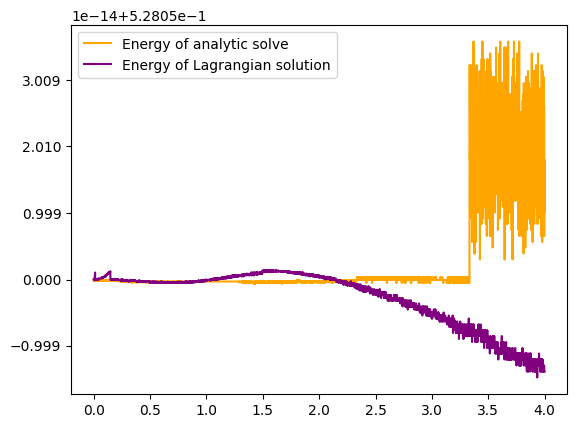

In [11]:
particle.plot_solved_dynamics(t, path, "Analytical solution")
particle.plot_solved_dynamics(t, tpath.detach(), "Lagrangian solution")
plt.legend()
plt.show()

En = [particle.energy(x) for x in path]
Ent = [particle.energy(x) for x in tpath.detach()]

plt.plot(t, En, color='orange', label='Energy of analytic solve')
plt.plot(t, Ent, color='purple', label= 'Energy of Lagrangian solution')
plt.legend()
plt.show()

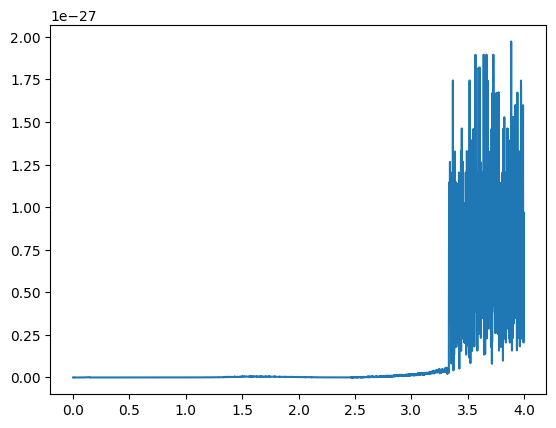

In [12]:
# Mean square difference between analytical straight solution and analytical Lagrangian solution.

plt.plot(t, np.sum((tpath.detach().numpy() - path)**2, axis=1))

In [13]:
def random_initialize(start, end, dim, n, seed=None, device = None):
    if device == None:
        device = torch.device('cpu')
    gen = torch.Generator()
    if seed != None:
        gen.manual_seed(seed)
    return torch.rand((n, dim), generator=gen).to(device)*(end - start) + start


def create_training_data(n, dimension, position_tuple, velocity_tuple, seed, device=None):
    # Make a torch tensor with n random starting positions and velocities using uniform distribution:
    # Merge them into a single tensor.
    state = torch.cat([random_initialize(*position_tuple, dimension, n, seed, device), random_initialize(*velocity_tuple, dimension, n, seed*2, device)], dim=1)
    diff_state = torch.tensor(analytically_differentiated_state(state, 0, particle.solve_acceleration)).float()
    if (device != None):
        return [state.to(device), diff_state.to(device)]
    
    return [state, diff_state]


In [14]:
def create_test_data(number_of_batches, batch_len, time_step, dimension, position_tuple, 
                                                    velocity_tuple, seed, device=None):
    state_list = []
    diff_state_list = []
    t_test = torch.arange(0, time_step*batch_len, time_step)
    
    if device == None:
        device = torch.device('cpu')
    for i in range(number_of_batches):
        gen = torch.Generator()
        gen.manual_seed(seed+i)
        start_pos_vector = torch.rand(dimension, generator = gen)*(position_tuple[1] - position_tuple[0]) + position_tuple[0]
        
        gen2 = torch.Generator()
        gen2.manual_seed(seed*2+i*2)
        start_vel_vector = torch.rand(dimension, generator = gen)*(velocity_tuple[1] - velocity_tuple[0]) + velocity_tuple[0]
        q_qdot = torch.tensor(ode_solve_analytic(start_pos_vector, start_vel_vector, t_test, particle.solve_acceleration)).float()
        qdot_qdotdot = analytically_differentiated_state(q_qdot, t_test, particle.solve_acceleration)
        
        if (device != None):
            q_qdot = q_qdot.to(device)
            qdot_qdotdot = qdot_qdotdot.to(device)
            
        state_list.append(q_qdot)
        diff_state_list.append(qdot_qdotdot)
    
    return [state_list, diff_state_list, t_test]


In [15]:
# "Normalize", otherwise nn weights and losses explode badly.

# In a physical system, normalization is just a unit conversion. We are just scaling our coordinates.

# We only consider train_data to normalize but use the same limiting parameters to create the test data
# so that our normalization works good.

def normalize_training_data(training_data):
    maximum = torch.max(torch.abs(training_data[0]))
    maximum = max(maximum, torch.max(torch.abs(training_data[1])))
    training_data[0] = training_data[0]/maximum
    training_data[1] = training_data[1]/maximum
    return maximum.item(), training_data
        
def normalize_testing_data(testing_data, maximum):
    for i in range(len(testing_data[0])):
        testing_data[0][i] = testing_data[0][i]/maximum
        testing_data[1][i] = testing_data[1][i]/maximum
    return testing_data

In [16]:
device = torch.device("cuda")

total_data_points = 4000
position_start_end = particle.position_bounds
velocity_start_end = particle.velocity_bounds
train_seed = 86 
training_data = create_training_data(total_data_points, particle.dof//2, 
                                        position_start_end, velocity_start_end, 
                                        seed = train_seed, device=device)

/tmp/ipykernel_34/1391046877.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  diff_state = torch.tensor(analytically_differentiated_state(state, 0, particle.solve_acceleration)).float()


In [17]:
scale_factor, training_data = normalize_training_data(training_data)


print("Scale factor:", scale_factor)

q_qdot_train, qdot_qdotdot_train = training_data

print("State",q_qdot_train)
print("Differentiated state", qdot_qdotdot_train)



Scale factor: 1.9992473125457764
State tensor([[ 0.4339, -0.5064],
        [ 0.1131, -0.5842],
        [ 0.0079,  0.7997],
        ...,
        [ 0.1741,  0.3823],
        [ 0.4811, -0.3665],
        [ 0.0236,  0.3317]], device='cuda:0')
Differentiated state tensor([[-0.5064, -0.5002],
        [-0.5842, -0.5002],
        [ 0.7997, -0.5002],
        ...,
        [ 0.3823, -0.5002],
        [-0.3665, -0.5002],
        [ 0.3317, -0.5002]], device='cuda:0')


In [18]:
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

class LNN(nn.Module):
    def __init__(self, input_size, device):
        super(LNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)
        if (device != None):
            self.device = device
            self.fc1 = self.fc1.to(device)
            self.fc2 = self.fc2.to(device)
            self.fc3 = self.fc3.to(device)
        else:
            self.device = torch.device("cpu")
    
    def lagrangian(self, x):
        
        x = F.softplus(self.fc1(x))
        x = F.softplus(self.fc2(x))
        x = self.fc3(x)
        
        return x 

    def forward(self, x):
        n = x.shape[1]//2
        xv = torch.autograd.Variable(x, requires_grad=True)
        xv_tup = tuple([xi for xi in x]) 

        #xv_tup is tuple of "states" in various time frames.
        tqt = xv[:, n:]

        jacpar = partial(jacobian,  self.lagrangian, create_graph=True)
        hesspar = partial(hessian,  self.lagrangian, create_graph=True)

        A = tuple(map(hesspar, xv_tup))
        B = tuple(map(jacpar, xv_tup))
        #print("b",B)
        #Why tuple?

        #print("A:", A)
        
        multi = lambda Ai, Bi, tqti, n:  torch.pinverse(Ai[n:, n:]) @ (Bi[0][:n] - Ai[n:, :n] @ tqti) 
        multi_par = partial(multi, n=n)

        tqtt_tup = tuple(map(multi_par, A, B, tqt))
        tqtt = torch.cat([tqtti[None] for tqtti in tqtt_tup])

        xt = torch.cat([tqt, tqtt], axis=1)
        if self.training:
            xt.retain_grad()
        return xt
    
    
    def fit(self, num_epochs, batch_size, optimizer, train_loader, valid_loader=None, 
                                                                        scheduler=None, validate=False):
        for epoch in range(1, num_epochs + 1):
            self.train()  # Set model to training mode
            train_loss = 0.0
            
            for xi, yi in train_loader:
                optimizer.zero_grad()
                qdot_qdotdot_pred = self(xi)
                loss_val = loss(qdot_qdotdot_pred, yi)
                print(loss_val)
                loss_val.backward()
                optimizer.step()
                train_loss += loss_val.item()
                
                
                
            train_loss /= len(train_loader)
                
            scheduler.step(train_loss)
            
            print(f'Epoch {epoch}/{num_epochs}, Train Loss: {train_loss}', end = '')
            
            if validate:
                self.eval()
                valid_loss = 0.0
                with torch.no_grad():
                    for xi, yi in valid_loader:
                        qdot_qdotdot_pred = self(xi)
                        loss_val = loss(qdot_qdotdot_pred, yi)
                        valid_loss += loss_val.item()
                    valid_loss /= len(valid_loader)
                print(f', Valid Loss: {valid_loss}', end = '')
                
            print()

    def t_forward(self, t, x):
        return self.forward(x)
    
    def plot_lagrangian(self, x):
        return self.lagrangian(torch.Tensor(x)).cpu().detach()
    

def loss(pred, targ):
    return torch.mean(torch.abs(pred[:,1] - targ[:,1]))
 

In [19]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
train_needed = 0


if train_needed == 1:
    eps = 64
    batch_size = 64
    model = LNN(particle.dof, device)

    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = ReduceLROnPlateau(optimizer, 'min')
    loss_list = []
    for e in range(eps):
        running_loss = 0.
        for i in range(1, len(q_qdot_train) // batch_size):
            optimizer.zero_grad()
            xi = q_qdot_train[(i-1)*batch_size:i*batch_size]
            qdot_qdotdot_pred = model(xi)
            loss_val = loss(qdot_qdotdot_pred, qdot_qdotdot_train[(i-1)*batch_size:i*batch_size])
            loss_val.backward()

            optimizer.step()

            running_loss += loss_val.item()
        scheduler.step(running_loss)
    
        print('Epoch %d loss: %.10f' % (e + 1, running_loss/len(q_qdot_train)))
        loss_list.append(running_loss/len(q_qdot_train))
elif train_needed == 0:
    if trial == 0:
        model = torch.load('/kaggle/input/constant_force/pytorch/64-epoch-best-fit/1/model_may12_3.pt')
    if trial == 1:
        model = torch.load('/kaggle/input/first_model_lnn/pytorch/first/1/harmonic.pt')
    model.eval()

In [20]:
torch.save(model, '/kaggle/working/model_may12_3.pt')

In [21]:
batch_number = 4
test_batch_len = 1000
time_step = 0.001
test_seed = 96
particle.scale_constants(1)

testing_data = create_test_data(batch_number, test_batch_len, 
                                    time_step, particle.dof//2, 
                                    position_start_end, velocity_start_end, 
                                    seed = test_seed, device = device)

testing_data = normalize_testing_data(testing_data, scale_factor)
q_qdot_test_list, qdot_qdotdot_test_list, t_test = testing_data

particle.scale_constants(scale_factor)

print("Test state 0:",q_qdot_test_list[0][0:10])
print("Test differentiated state 0:",qdot_qdotdot_test_list[0][0:10])

Test state 0: tensor([[0.4801, 0.3162],
        [0.4804, 0.3157],
        [0.4807, 0.3152],
        [0.4810, 0.3147],
        [0.4814, 0.3142],
        [0.4817, 0.3137],
        [0.4820, 0.3132],
        [0.4823, 0.3127],
        [0.4826, 0.3122],
        [0.4829, 0.3117]], device='cuda:0')
Test differentiated state 0: tensor([[ 0.3162, -0.5002],
        [ 0.3157, -0.5002],
        [ 0.3152, -0.5002],
        [ 0.3147, -0.5002],
        [ 0.3142, -0.5002],
        [ 0.3137, -0.5002],
        [ 0.3132, -0.5002],
        [ 0.3127, -0.5002],
        [ 0.3122, -0.5002],
        [ 0.3117, -0.5002]], device='cuda:0')


In [22]:
train_needed = 3

if train_needed == 1:
    num_epochs = 100
    batch_size = 32
    
    model = LNN(particle.dof, device)
    model.to(device)
    
    
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = ReduceLROnPlateau(optimizer, 'min')
    train_dataset = TensorDataset(q_qdot_train, qdot_qdotdot_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    q_qdot_valid = torch.cat(q_qdot_test_list)
    qdot_qdotdot_valid = torch.cat(qdot_qdotdot_test_list)
    valid_dataset = TensorDataset(q_qdot_valid, qdot_qdotdot_valid)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    validate = True
    
    model = LNN(particle.dof, device)
    model.to(device)
    model.fit(num_epochs, batch_size, optimizer, train_loader, valid_loader, scheduler, validate)
elif train_needed == 0:
    if trial == 0:
        model = torch.load('/kaggle/input/constant_force/pytorch/second_working_model/1/constant_force.pt')
    if trial == 1:
        model = torch.load('/kaggle/input/first_model_lnn/pytorch/first/1/harmonic.pt')
    model.eval()

In [23]:
def nn_solve_ode(model, x0, t, device=None):
    if device == None:
        device = torch.device('cpu')
    x0 = x0.cpu().detach().numpy()
    def f(x, t):
        x_tor = torch.tensor(np.expand_dims(x, 0), requires_grad=True).float()
        return np.squeeze(model(x_tor.to(device)).cpu().detach().numpy(), axis=0)
    return odeint(f, x0, t) 

In [24]:

#t_test should be either decreasing or increasing!!!

#If ODE does not return any errors or warning, then it's probably ok!!
nn_test_list = []

for test_data in q_qdot_test_list:
    nn_test_list.append(nn_solve_ode(model, test_data[0], t_test, device))
    print("Solved one")


Solved one
Solved one
Solved one
Solved one


In [25]:
for i in range(50):
    print((nn_test_list[0][i], q_qdot_test_list[0][i]))
    
#predis= model(q_qdot_test_list[0])
    

(array([0.4801026 , 0.31615448]), tensor([0.4801, 0.3162], device='cuda:0'))
(array([0.48041849, 0.31565348]), tensor([0.4804, 0.3157], device='cuda:0'))
(array([0.48073389, 0.31515247]), tensor([0.4807, 0.3152], device='cuda:0'))
(array([0.48104879, 0.31465145]), tensor([0.4810, 0.3147], device='cuda:0'))
(array([0.48136319, 0.31415043]), tensor([0.4814, 0.3142], device='cuda:0'))
(array([0.48167709, 0.31364941]), tensor([0.4817, 0.3137], device='cuda:0'))
(array([0.48199049, 0.31314838]), tensor([0.4820, 0.3132], device='cuda:0'))
(array([0.48230339, 0.31264734]), tensor([0.4823, 0.3127], device='cuda:0'))
(array([0.48261579, 0.3121463 ]), tensor([0.4826, 0.3122], device='cuda:0'))
(array([0.48292768, 0.31164526]), tensor([0.4829, 0.3117], device='cuda:0'))
(array([0.48323908, 0.31114421]), tensor([0.4832, 0.3112], device='cuda:0'))
(array([0.48354997, 0.31064316]), tensor([0.4836, 0.3107], device='cuda:0'))
(array([0.48386036, 0.3101421 ]), tensor([0.4839, 0.3102], device='cuda:0'))

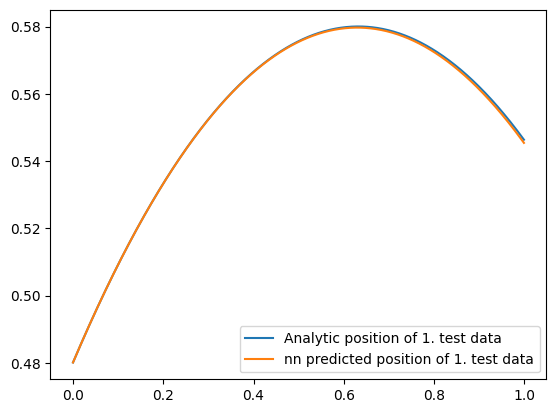

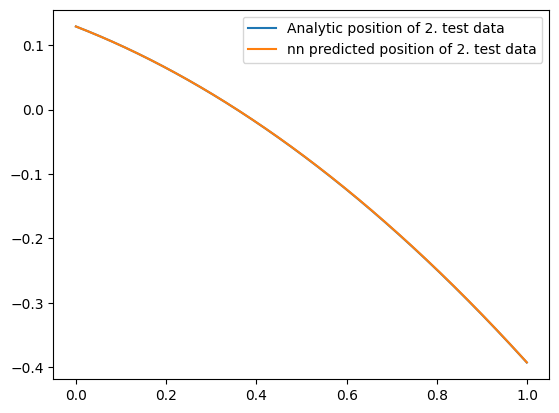

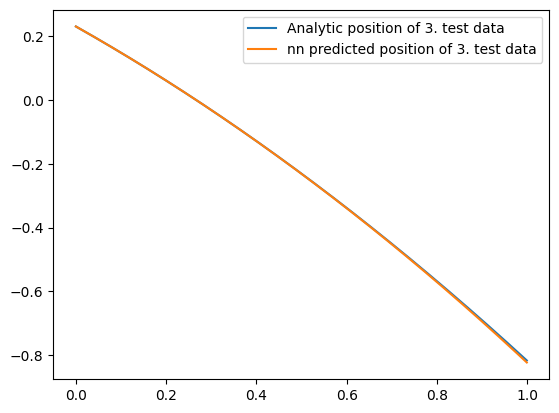

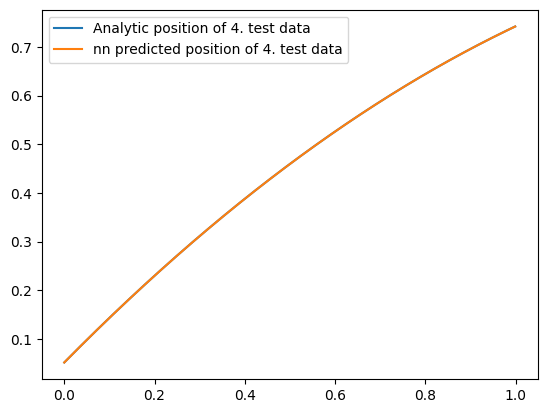

In [26]:
for i in range(len(nn_test_list)):
    particle.plot_solved_dynamics(t_test, q_qdot_test_list[i].cpu(), labelstr = "Analytic position of {}. test data".format(i+1))
    particle.plot_solved_dynamics(t_test, nn_test_list[i], labelstr = "nn predicted position of {}. test data".format(i+1))
    plt.legend()
    plt.show()

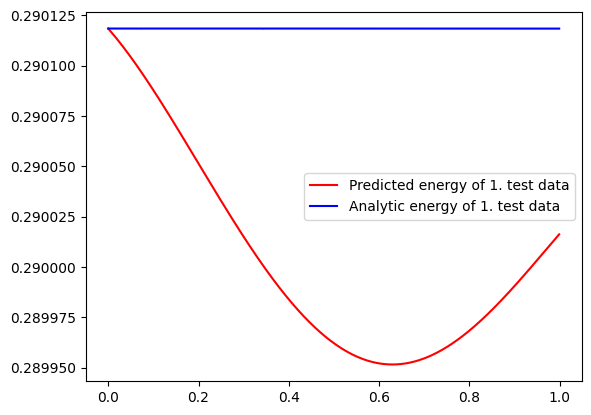

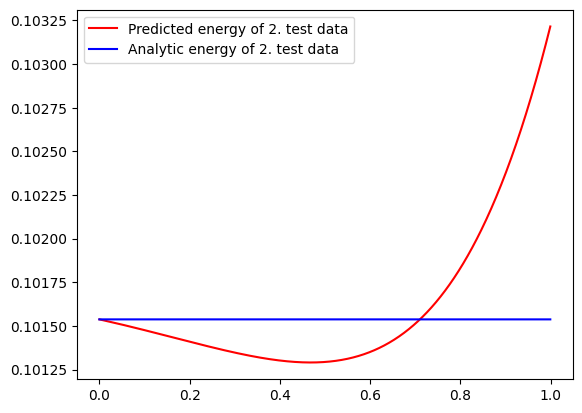

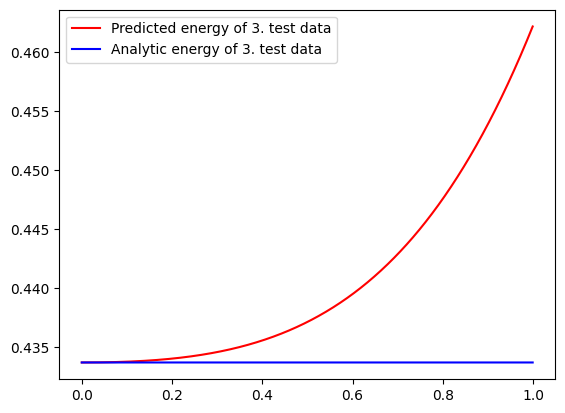

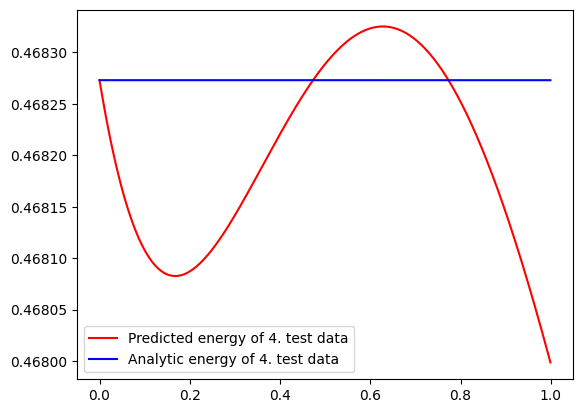

In [27]:
for i in range(len(nn_test_list)):
    E_test = [particle.energy(x) for x in q_qdot_test_list[i].cpu()]
    E_lnn = [particle.energy(x) for x in nn_test_list[i]]
    plt.plot(t_test, E_lnn, color='red', label='Predicted energy of {}. test data'.format(i+1))
    plt.plot(t_test, E_test, color='blue', label='Analytic energy of {}. test data'.format(i+1))
    plt.legend()
    plt.show()



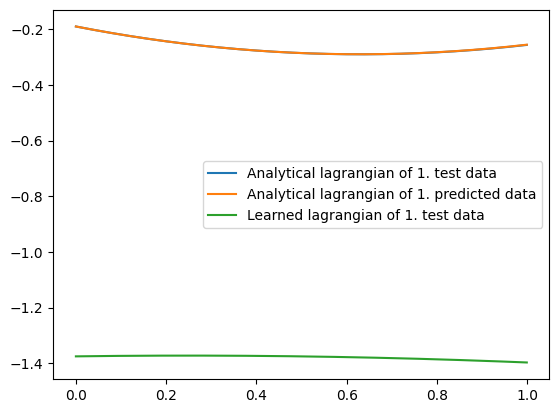

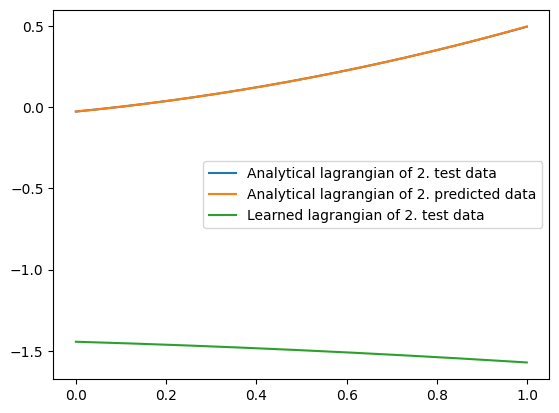

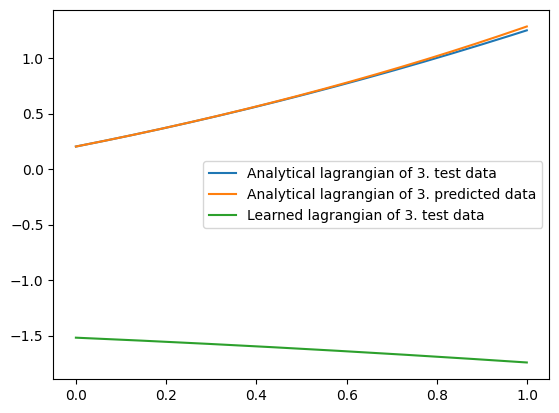

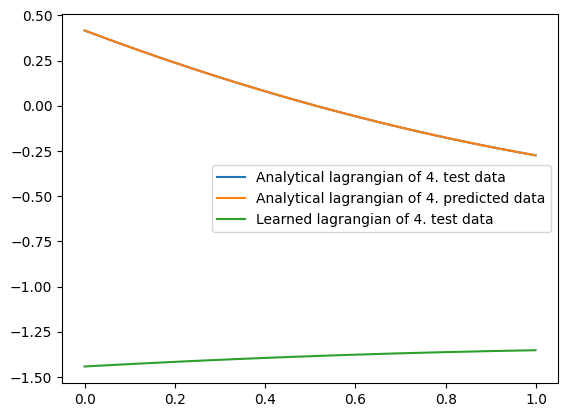

In [28]:
# Plotting lagrangians

# Future work: see whether the difference is close to a total derivative! Lagrangian is not unique.

for i in range(len(nn_test_list)):
    particle.plot_lagrangian(t_test, q_qdot_test_list[i].cpu(), particle.lagrangian, 'Analytical lagrangian of {}. test data'.format(i+1))
    particle.plot_lagrangian(t_test, nn_test_list[i], particle.lagrangian, 'Analytical lagrangian of {}. predicted data'.format(i+1))
    particle.plot_lagrangian(t_test, q_qdot_test_list[i], model.plot_lagrangian, 'Learned lagrangian of {}. test data'.format(i+1))
    plt.legend()
    plt.show()

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


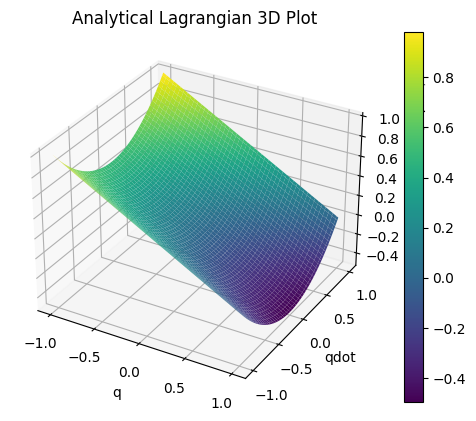

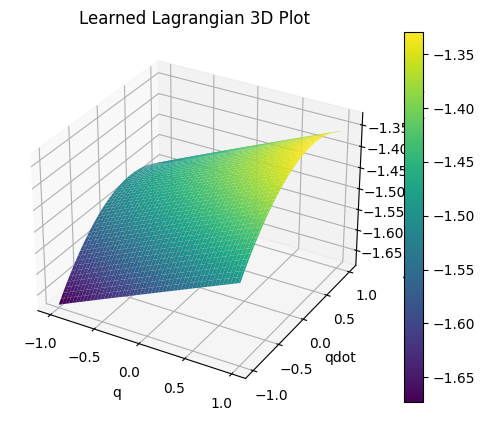

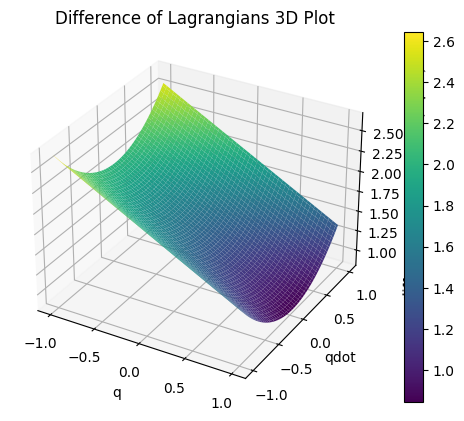

In [29]:
from mpl_toolkits.mplot3d import Axes3D

def Lagr(x, y):
    xy_stacked = (x, y)
    return particle.lagrangian(xy_stacked)

plot_n = 100

# Generate x and y values
x = torch.linspace(-1,1,plot_n)
y = torch.linspace(-1,1,plot_n)

# Generate meshgrid
X, Y = torch.meshgrid(x, y)
Z = Lagr(X,Y)
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X, Y, Z, cmap='viridis')

# Add labels and title
ax.set_xlabel('q')
ax.set_ylabel('qdot')
ax.set_zlabel('analytical lagrangian(q, qdot)')
ax.set_title('Analytical Lagrangian 3D Plot')

# Add color bar
fig.colorbar(surf)

# Show the plot
plt.show()


def learned_lagr(x, y, device = None):
    if device==None:
        device = torch.device('cpu')
    xy_stacked = torch.stack([x.flatten(), y.flatten()],dim=1).to(device)
    return model.plot_lagrangian(xy_stacked)

Z_learned = torch.reshape(learned_lagr(X, Y, device), (plot_n,plot_n)).cpu()

# Create a 3D plot
fig = plt.figure()
# Create 3D plot
ax = fig.add_subplot(1, 1, 1, projection='3d')
surf = ax.plot_surface(X, Y, Z_learned, cmap='viridis')
ax.set_xlabel('q')
ax.set_ylabel('qdot')
ax.set_zlabel('learned lagrangian(q, qdot)')
ax.set_title('Learned Lagrangian 3D Plot')
fig.colorbar(surf, ax=ax)
plt.show()


fig = plt.figure()
# Create 3D plot
ax = fig.add_subplot(1, 1, 1, projection='3d')
surf = ax.plot_surface(X, Y, Z-Z_learned, cmap='viridis')
ax.set_xlabel('q')
ax.set_ylabel('qdot')
ax.set_zlabel('difference of lagrangians(q, qdot)')
ax.set_title('Difference of Lagrangians 3D Plot')
fig.colorbar(surf, ax=ax)
plt.show()


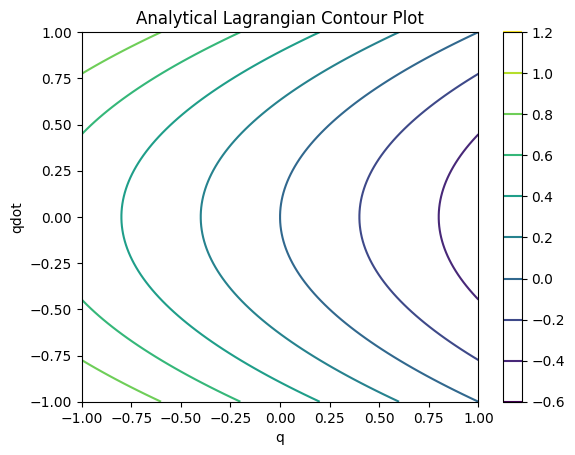

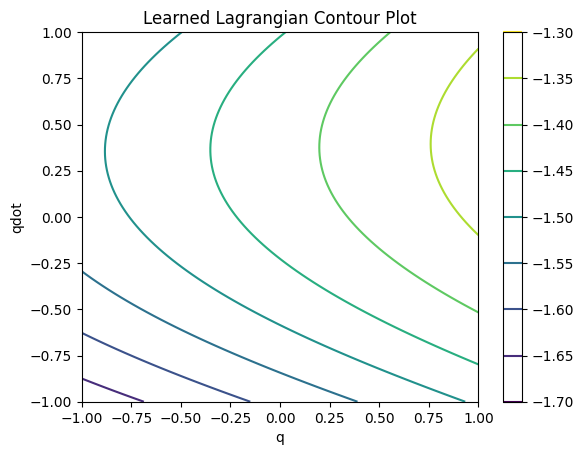

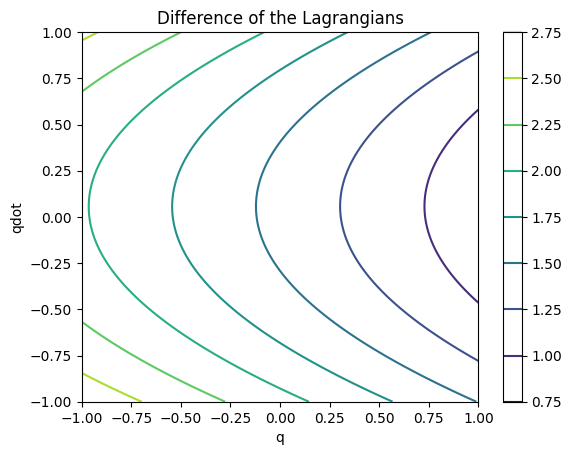

In [30]:
fig = plt.figure()
# Create contour plot
ax = fig.add_subplot(1, 1, 1)
contour = ax.contour(X, Y, Z, cmap='viridis')
ax.set_xlabel('q')
ax.set_ylabel('qdot')
ax.set_title('Analytical Lagrangian Contour Plot')
fig.colorbar(contour, ax=ax)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
contour = ax.contour(X, Y, Z_learned, cmap='viridis')
ax.set_xlabel('q')
ax.set_ylabel('qdot')
ax.set_title('Learned Lagrangian Contour Plot')
fig.colorbar(contour, ax=ax)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
contour = ax.contour(X, Y, Z-Z_learned, cmap='viridis')
ax.set_xlabel('q')
ax.set_ylabel('qdot')
ax.set_title('Difference of the Lagrangians')
fig.colorbar(contour, ax=ax)


#plt.subplots_adjust(wspace=1)
# Show the plot
plt.show()


In [31]:
%pip install pysr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.3/76.3 kB 3.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [32]:
from pysr import PySRRegressor


/opt/conda/lib/python3.10/site-packages/juliacall/__init__.py:60: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  warnings.warn(


[juliapkg] Found dependencies: /opt/conda/lib/python3.10/site-packages/juliapkg/juliapkg.json
[juliapkg] Found dependencies: /opt/conda/lib/python3.10/site-packages/pysr/juliapkg.json
[juliapkg] Found dependencies: /opt/conda/lib/python3.10/site-packages/juliacall/juliapkg.json
[juliapkg] Locating Julia ~1.6.7, ~1.7, ~1.8, ~1.9, =1.10.0, ^1.10.3
[juliapkg] Querying Julia versions from https://julialang-s3.julialang.org/bin/versions.json
[juliapkg] WARNING: About to install Julia 1.10.3 to /root/.julia/environments/pyjuliapkg/pyjuliapkg/install.
[juliapkg]   If you use juliapkg in more than one environment, you are likely to have Julia
[juliapkg]   installed in multiple locations. It is recommended to install JuliaUp
[juliapkg]   (https://github.com/JuliaLang/juliaup) or Julia (https://julialang.org/downloads)
[juliapkg]   yourself.
[juliapkg] Downloading Julia from https://julialang-s3.julialang.org/bin/linux/x64/1.10/julia-1.10.3-linux-x86_64.tar.gz
             download complete
[jul

┌ Warning: could not download https://pkg.julialang.org/registries
│   exception = RequestError: HTTP/2 502 while requesting https://pkg.julialang.org/registries
└ @ Pkg.Registry ~/.julia/environments/pyjuliapkg/pyjuliapkg/install/share/julia/stdlib/v1.10/Pkg/src/Registry/Registry.jl:69
  Installing known registries into `~/.julia`
┌ Warning: could not download https://pkg.julialang.org/registries
│   exception = RequestError: HTTP/2 502 while requesting https://pkg.julialang.org/registries
└ @ Pkg.Registry ~/.julia/environments/pyjuliapkg/pyjuliapkg/install/share/julia/stdlib/v1.10/Pkg/src/Registry/Registry.jl:69
┌ Warning: could not download https://pkg.julialang.org/registries
│   exception = RequestError: HTTP/2 502 while requesting https://pkg.julialang.org/registries
└ @ Pkg.Registry ~/.julia/environments/pyjuliapkg/pyjuliapkg/install/share/julia/stdlib/v1.10/Pkg/src/Registry/Registry.jl:69
     Cloning registry from "https://github.com/JuliaRegistries/General.git"
       Added r

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [33]:
inp= torch.stack((X.flatten(),Y.flatten()), dim=1)
output = particle.lagrangian((X.flatten(),Y.flatten()))
print(output.shape)
#print(inp.shape,output.shape)
sym_model = PySRRegressor(binary_operators=["+", "-", "*", "/"])
sym_model.fit(inp, output)
print(sym_model)

torch.Size([10000])
Compiling Julia backend...


/opt/conda/lib/python3.10/site-packages/pysr/sr.py:1307: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 2.750e+04
Head worker occupation: 19.7%
Progress: 66 / 600 total iterations (11.000%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           8.174e-01  1.594e+01  y = x₀
3           5.203e-02  1.377e+00  y = x₀ * -0.50018
5           2.312e-02  4.055e-01  y = 0.50019 * (0.33994 - x₀)
7           1.460e-03  1.381e+00  y = (x₀ - (x₁ * x₁)) * -0.44851
9           0.000e+00  7.971e+00  y = (-0.50019 * x₀) + ((0.5 * x₁) * x₁)
---------------------------------------------------------------------------------------------------
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 2.920e+04
Head worker occupation: 16.3%
Progress: 156 / 600 total iterations (26.000%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equati

In [34]:
output2 = model.plot_lagrangian(inp.to(device))
print(output2.shape)
#print(inp.shape,output.shape)
sym_model2 = PySRRegressor(binary_operators=["+", "-", "*", "/"])
sym_model2.fit(inp, output2)
print(sym_model2)

torch.Size([10000, 1])


/opt/conda/lib/python3.10/site-packages/pysr/sr.py:1307: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 3.050e+04
Head worker occupation: 18.8%
Progress: 78 / 600 total iterations (13.000%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
3           5.081e-03  5.314e+00  y = -0.21523 + -1.2461
5           2.240e-03  4.095e-01  y = -1.4613 - (-0.091396 * x₀)
7           8.327e-04  4.948e-01  y = (0.079029 * (x₀ + x₁)) + -1.4613
9           7.332e-04  6.358e-02  y = (((x₁ / 1.2818) + x₀) * 0.089121) - 1.4611
11          2.689e-04  5.016e-01  y = ((x₀ - (x₁ * (x₁ - 0.80835))) * 0.071555) - 1.4459
13          1.752e-04  2.141e-01  y = (0.089121 * ((x₀ + 0.32773) - ((x₁ * x₁) - x₁))) - 1.4611
15          1.593e-06  2.350e+00  y = ((x₀ - (((x₁ - 0.04866) + 0.179) * (x₁ - 0.86437))) * 0.09...
                                  0817) - 1.4406
---------------------------------------------------------------------------------------------------
Press 'q' and t

In [36]:
inp= torch.stack((X.flatten(),Y.flatten()), dim=1)
output3 = torch.unsqueeze(particle.lagrangian((X.flatten(),Y.flatten())),1) - model.plot_lagrangian(inp.to(device))
print(output3.shape)
#print(inp.shape,output.shape)
sym_model3 = PySRRegressor(binary_operators=["+", "-", "*", "/"])
sym_model3.fit(inp, output3)
print(sym_model3)

torch.Size([10000, 1])


/opt/conda/lib/python3.10/site-packages/pysr/sr.py:1307: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 3.170e+04
Head worker occupation: 17.7%
Progress: 75 / 600 total iterations (12.500%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
3           9.029e-02  5.314e+00  y = 1.6313 - x₀
5           3.357e-02  4.948e-01  y = 1.6313 - (x₀ * 0.59158)
9           2.752e-02  4.963e-02  y = (x₁ * x₁) + (1.393 - (x₀ * 0.59128))
11          2.332e-03  1.234e+00  y = (x₁ * (x₁ / 1.4708)) + (1.393 - (x₀ * 0.59128))
13          1.649e-03  1.731e-01  y = ((x₁ * 0.59128) * x₁) + ((1.393 * 1.0351) - (x₀ * 0.59128)...
                                  )
15          1.513e-03  4.327e-02  y = ((x₁ / (-0.078688 / -0.04624)) * x₁) + (0.038024 + (1.393 ...
                                  - (x₀ * 0.59128)))
17          2.724e-05  2.008e+00  y = (((x₁ - 0.098598) / (-0.078688 / -0.04624)) * x₁) + (0.038...
                                  024 + (1.393 - (x₀ * 0.5912

In [43]:

print(sym_model3.latex(7))

- 0.592 x_{0} + x_{1} \cdot \left(0.589 x_{1} - 0.0667\right) + 1.43
